C:\Users\ak135\AppData\Local\Temp\ipykernel_9500\3490833649.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")


X_train shape: (570257, 32)
X_test shape: (142565, 32)
Number of classes: 5


c:\Users\ak135\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:57:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ak135\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:729: UserWarning: [17:57:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


Accuracy: 0.9828

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       251
           1       0.99      1.00      0.99    128943
           2       1.00      0.24      0.39        29
           3       0.87      0.71      0.78      3700
           4       0.95      0.93      0.94      9642

    accuracy                           0.98    142565
   macro avg       0.94      0.68      0.75    142565
weighted avg       0.98      0.98      0.98    142565



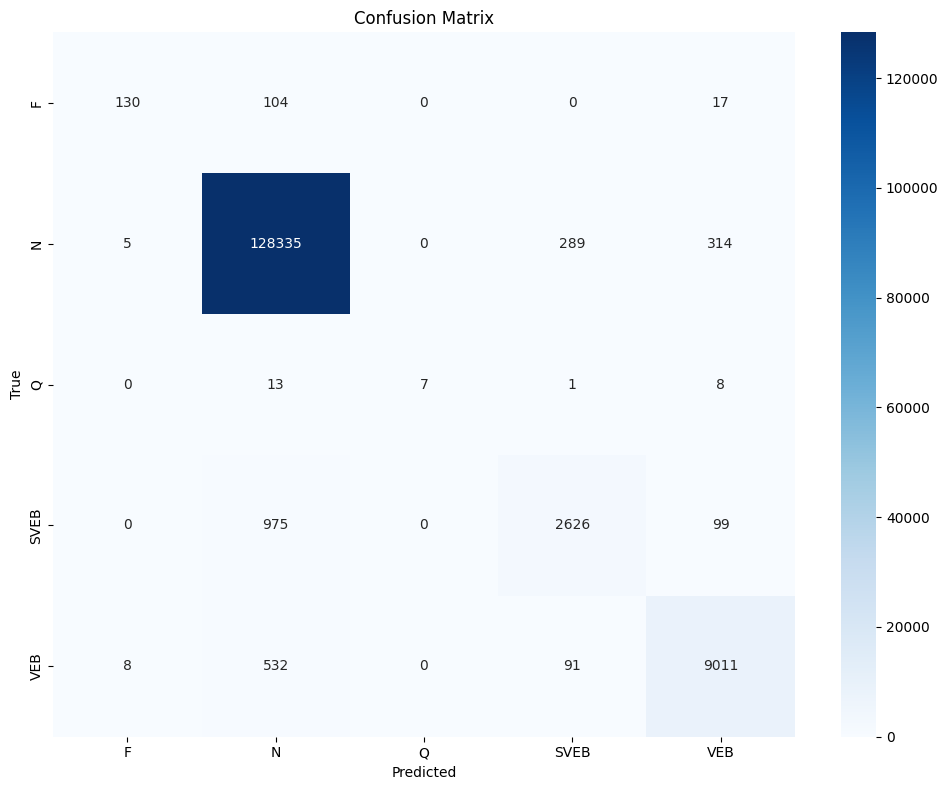

<Figure size 1000x800 with 0 Axes>

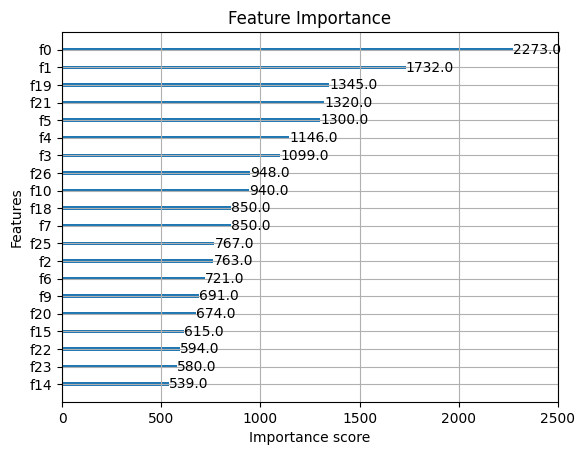

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combine datasets
df = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# Data cleaning and preprocessing
df.dropna(inplace=True)  # Handle missing values
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # Encode class labels

# Feature scaling
features = df.drop(['record', 'type'], axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
labels = df['type']

# Split data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42, stratify=labels)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Get number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Create DMatrix for XGBoost (optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'objective': 'multi:softmax',  # multi-class classification
    'num_class': num_classes,      # number of classes
    'eval_metric': 'mlogloss',     # metric for multi-class
    'eta': 0.1,                    # learning rate
    'max_depth': 6,                # maximum depth of a tree
    'subsample': 0.8,              # percentage of samples used per tree
    'colsample_bytree': 0.8,       # percentage of features used per tree
    'seed': 42,                    # random seed
    'tree_method': 'gpu_hist'      # use GPU acceleration if available
}

# Train the model
num_round = 100  # number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = bst.predict(dtest)
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


# Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(bst, max_num_features=20)  # show top 20 features
plt.title('Feature Importance')
plt.show()
